# Analysing magnetic materials using STEM-DPC

This notebook shows how to use the `pyXem` library to analyse 4-D scanning transmission electron microscopy (STEM) data, specifical magnetic materials using differential phase contrast (DPC). For more information about this imaging method, see the Wikipedia article on Scanning Transmission Electron Microscopy, which has a subsection on DPC: https://en.wikipedia.org/wiki/Scanning_transmission_electron_microscopy#Differential_phase_contrast

The data we'll be looking at there is from the paper **Strain Anisotropy and Magnetic Domains in Embedded Nanomagnets**, and is STEM data recorded on a Merlin fast pixelated electron detector system, where the objective lens has been turned off.
This allows for magnetic information to be extracted, by carefully mapping the beam shifts.

More documentation about pyXem is found at https://pyxem.readthedocs.io/

Journal article:
* **Strain Anisotropy and Magnetic Domains in Embedded Nanomagnets**
* Nord, M., Semisalova, A., Kákay, A., Hlawacek, G., MacLaren, I., Liersch, V., Volkov, O. M., Makarov, D., Paterson, G. W., Potzger, K., Lindner, J., Fassbender, J., McGrouther, D., Bali, R.
* Small 2019, 15, 1904738. https://doi.org/10.1002/smll.201904738

The full dataset and scripts used in analysing this data is found at Zenodo: https://zenodo.org/record/3466591

This notebook has been modified to use a cropped version of the data with only the infromation about the zero beam.

Refer to the link above to look at the entire dataset.

## Importing libraries

The first step is setting the plotting toolkit

In [ ]:
%matplotlib inline

Then import the library itself

In [ ]:
import hyperspy.api as hs
import pyxem as pxm

## Loading data

As the file is pretty big, we load it lazily.

In [ ]:
s = hs.load('data/10/fe60al40_stripe_pattern_very_small_dataset_cropped.hspy')

/Users/carterfrancis/mambaforge/envs/pyxem-demos/lib/python3.11/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/Users/carterfrancis/mambaforge/envs/pyxem-demos/lib/python3.11/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


In [ ]:
s

<Diffraction2D, title: Fe60Al40 stripe pattern, dimensions: (155, 80|64, 64)>

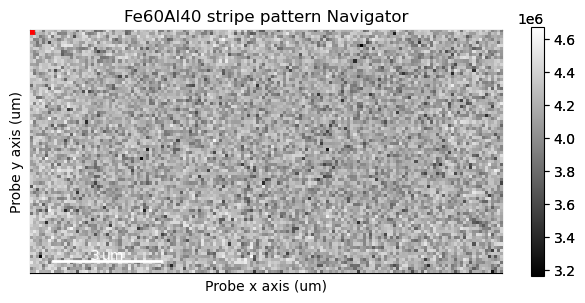

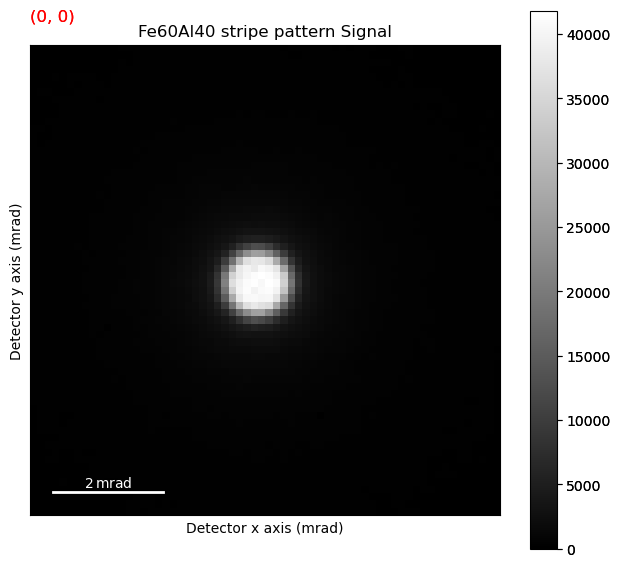

In [ ]:
s.plot()

## Plotting the data

Lets first have a look at the data, using the `slider` navigator.

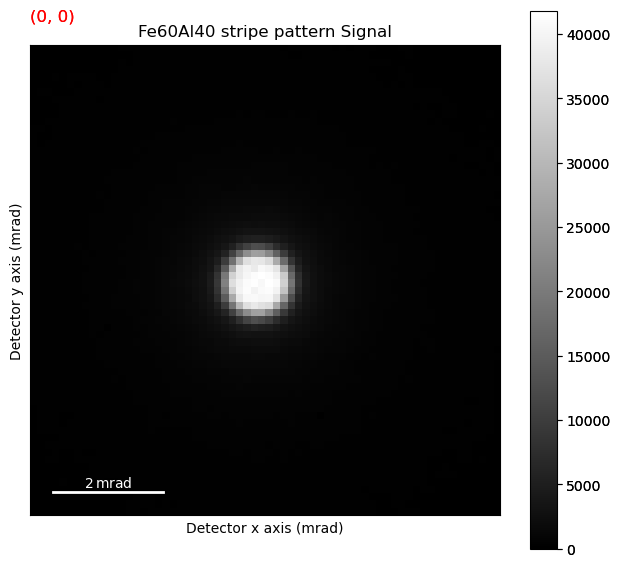

In [ ]:
s.plot(navigator='slider')

The direct beam is at (x, y) = (128, 125). Lets create a navigation signal from a single pixel in the direct beam.

In [ ]:
s_nav = s.isig[33, 29].T

This was pretty quick, thanks to how the chunking is for this dataset: (16, 16, 16, 16). So only about 0.4% of the full dataset had to be loaded into memory.

Plotting it, we can see the nanocrystalline structure of the material.

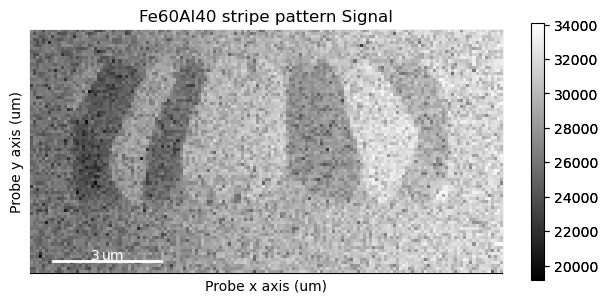

In [ ]:
s_nav.plot()

And then we can use it to navigate over the full dataset.

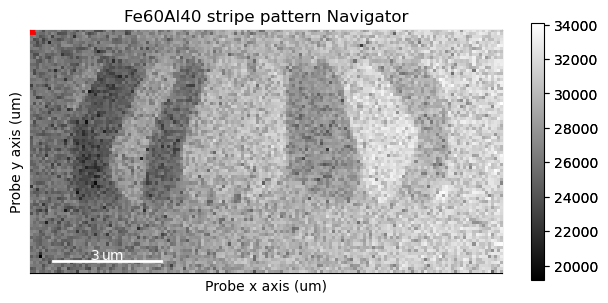

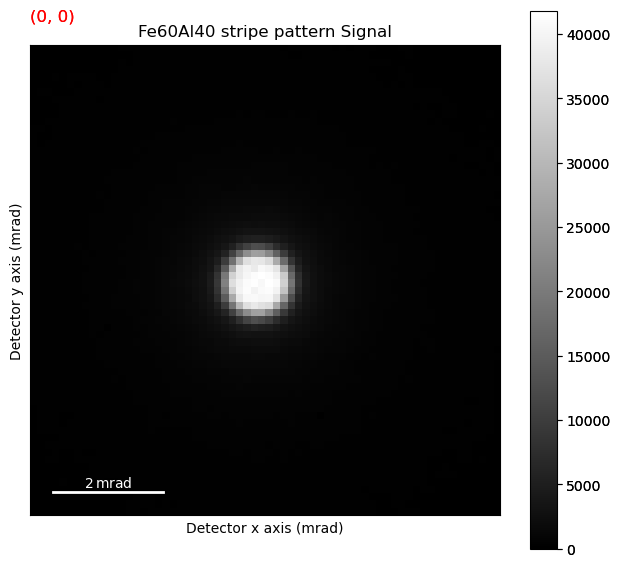

In [ ]:
s.plot(navigator=s_nav)

What we're interested in here is the movement of the centre beam. To make the plotting more responsive, we can grab just the centre of the diffraction patterns.

Move the navigator up and down in the centre of the sample, and look for small changes in the beam position.

In [ ]:
s

<Diffraction2D, title: Fe60Al40 stripe pattern, dimensions: (155, 80|64, 64)>

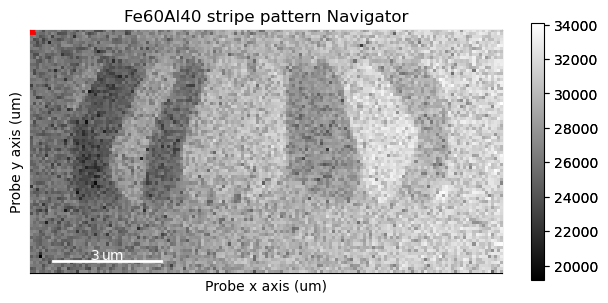

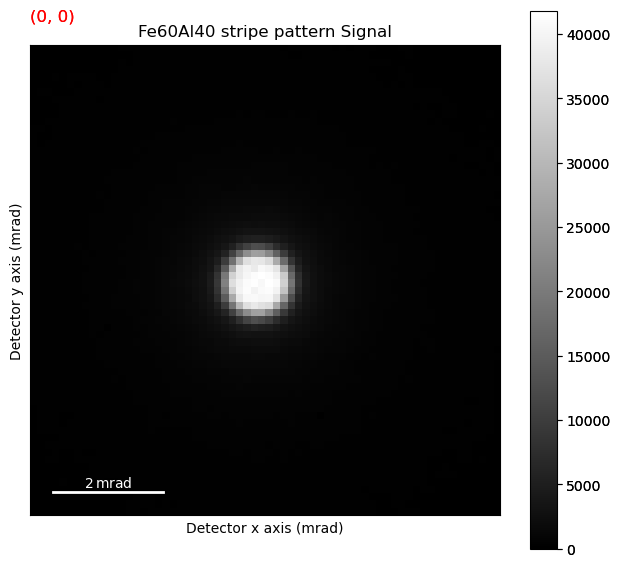

In [ ]:
s.plot(navigator=s_nav)

It can be really tricky noticing any systematic beam shifts. A better way is transposing the navigation dimensions.

## Navigation in the detector dimensions

A powerful feature in pyXem, which is inherited from HyperSpy, is the ability to "flip" the navigation dimensions.
So instead of navigating across the probe position, you can navigate over the detector positions.

Firstly, lets make a navigation signal for that, by averaging several of the diffraction patterns.
Here we use the `s_crop` signal from earlier.

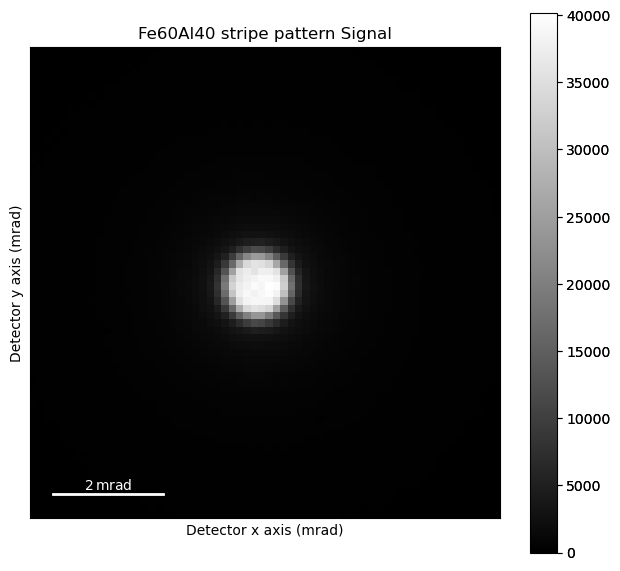

In [ ]:
s_diff_nav = s.inav[10:20, 10:20].mean(axis=(0, 1))
s_diff_nav.plot()

Then we transpose `s_crop`, and use `s_diff_nav` for navigation

In [ ]:
s_transpose = s.transpose()

Now, move the navigator across the direct beam, and look for the magnetic stripe in the signal plot.

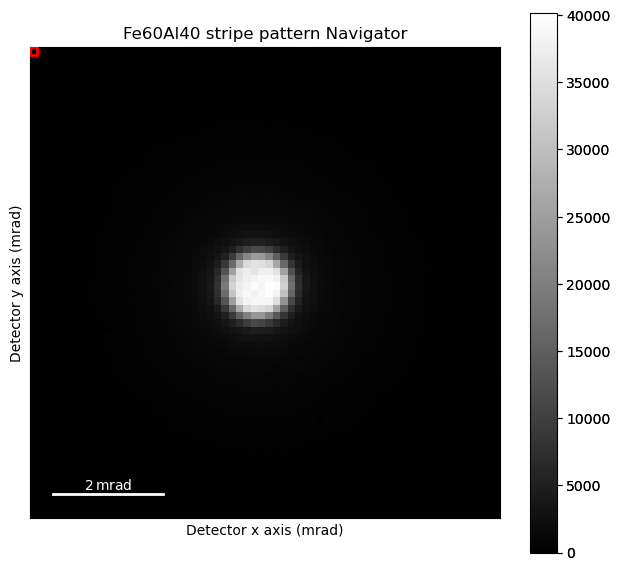

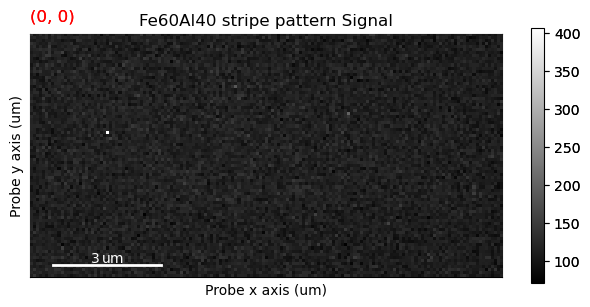

In [ ]:
#%matplotlib notebook
s_transpose.plot(navigator=s_diff_nav)

This visualizes the shift of the beam, which is caused by the beam passing through the ferromagnetic domains in the material.

However, it is not very quantitative. So lets try to extract the beam shifts using center of mass.

## Extracting the beam shift

There are many ways of extracting the beam shift. One way is using center of mass, which is a fairly simple method.

Again, we use `s_crop`, since we're only interested in the direct beam.

In [ ]:
s_crop_com = s.center_of_mass()

[########################################] | 100% Completed | 311.04 ms


This returns a `DPCSignal2D` class, which will be explored more later. What we need to know is that is it basically a HyperSpy `Signal2D` class, where the x-beam shifts are in the first navigation index (`s.inav[0]`), while the y-shifts are in the second navigation index (`s.inav[1]`).

Plotting it, we can see that the ferromagnetic domains are much more visible!

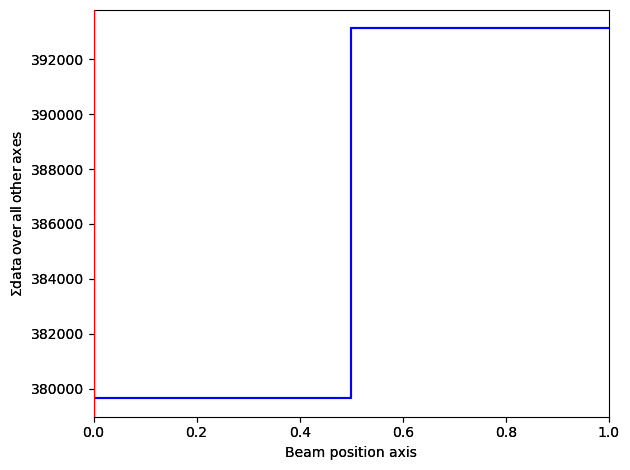

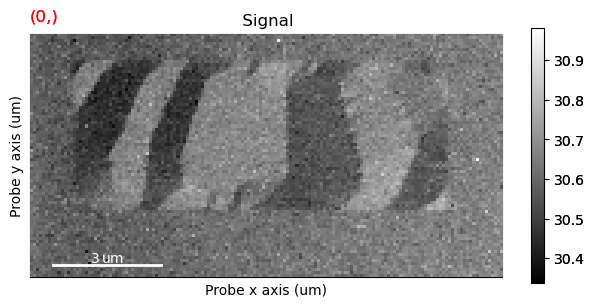

In [ ]:
s_crop_com.plot()

However, we're also getting contrast from the other effects, such as structural effects. Since the sample is nanocrystalline, some of the grains will be close to some zone axis, giving heavy Bragg scattering. While the Bragg spots themselves won't be visible at such low scattering angles as we have in `s_crop`, it will still change the intensity distribution _within_ the direct beam. Essentially, the direct beam becomes non-uniform, which will have an effect similarly to beam shift.

One way of reducing this is by using thresholding and masking. However, we first need to find reasonable values for these.

For this, we use `threshold_and_mask` on a subset of the dataset.

In [ ]:
s_subset = s.inav[:20, :20]

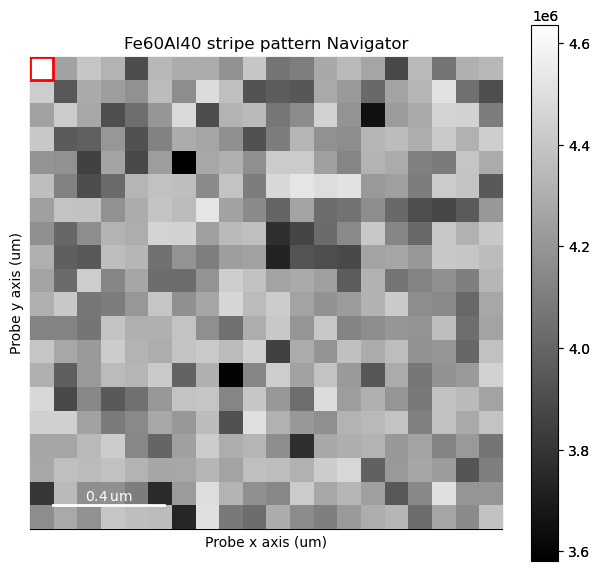

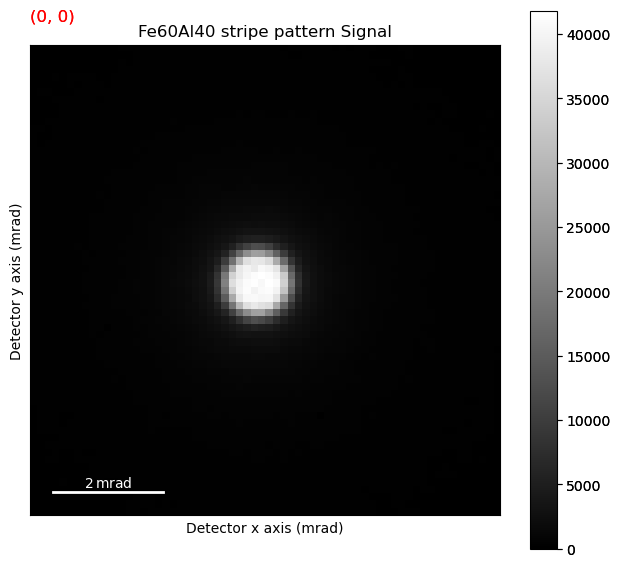

In [ ]:
s_subset.plot()

`threshold_and_mask` is a useful way to see what exactly what the pre-processing of the center of mass algorithm does, as we want to extract the beam shifts themselves, not intensity distributions _within_ the disk, or diffraction spots _outside_ the disk.

It works by getting the mean of the intensity inside the masked area, times the threshold. Then, any pixel lower or equal than that value is set to zero, while any value above that value is set to one. Ideally, this should remove the influence of other diffraction effects, and non-uniform direct beam.

In [ ]:
s_threshold_mask = s_subset.threshold_and_mask(threshold=3., mask=(16, 16,16))

[########################################] | 100% Completed | 105.27 ms


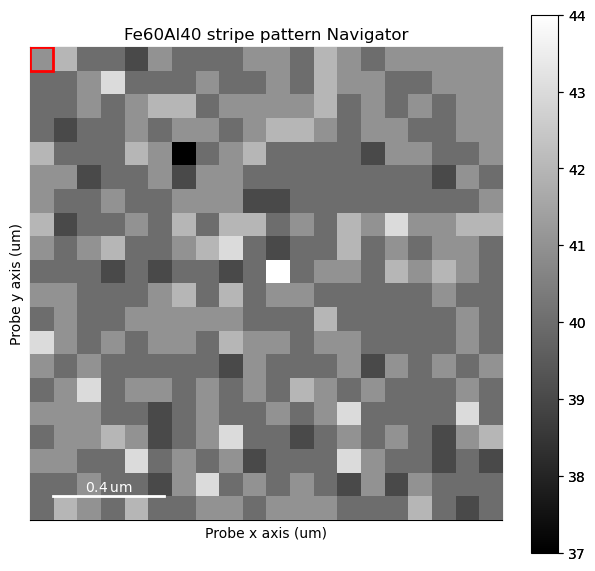

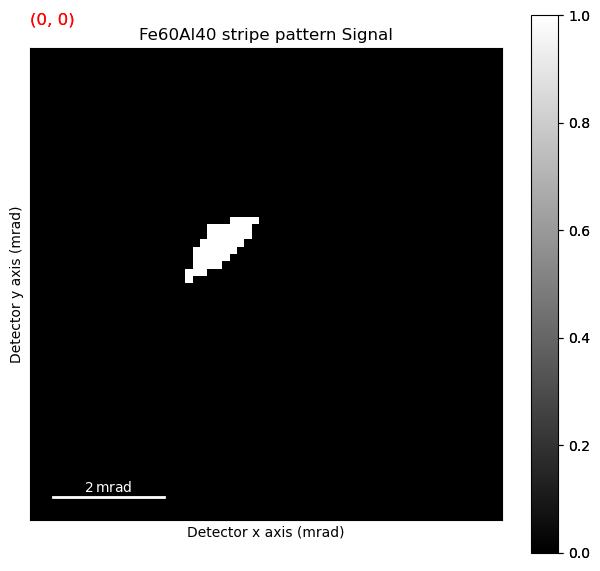

In [ ]:
s_threshold_mask.plot()

Having found some optimized parameters, we can use this to run the center of mass processing again.

In [ ]:
s_crop_com_threshold = s.center_of_mass(threshold=3., mask=(16, 16, 16), lazy_result=False)

[                                        ] | 0% Completed | 123.83 us

/Users/carterfrancis/mambaforge/envs/pyxem-demos/lib/python3.11/site-packages/pyxem/signals/diffraction2d.py:926: VisibleDeprecationWarning: Argument `lazy_result` is deprecated and will be removed in version 1.00.0. To avoid this warning, please do not use `lazy_result`. Use `lazy_output` instead. See the documentation of `center_of_mass()` for more details.
  since="0.15.0", name="lazy_result", alternative="lazy_output", removal="1.00.0"


[########################################] | 100% Completed | 428.41 ms


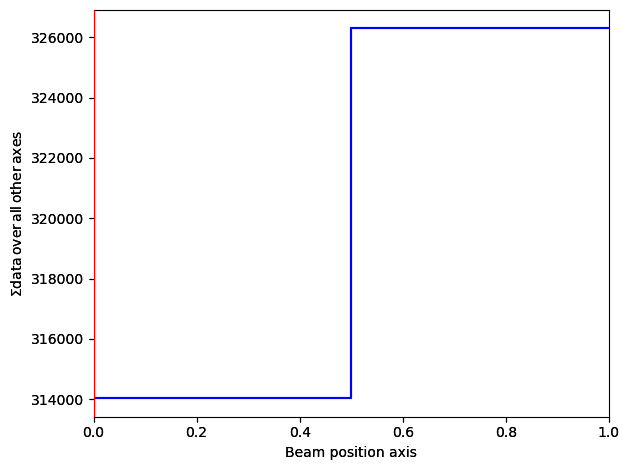

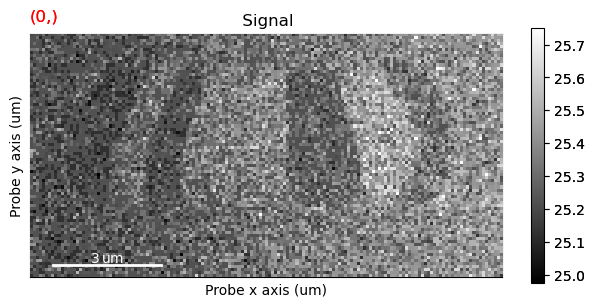

In [ ]:
s_crop_com_threshold.plot()

This seems to have improved it a little bit.

For doing more advanced processing of this type of data, see https://fpdpy.gitlab.io/fpd/, which has better edge detection algorithms in the `fpd.fpd_processing.phase_correlation` function. For a complete example on how to use this, see https://zenodo.org/record/3466591/files/d001_get_dpc_raw_signal.py which processes the same type of dataset as used in this example.

## Correcting d-scan

With the beam shift extracted, we will remove the effects of impure beam shift (d-scan).
This is due to various instrument misalignments, and leads to a change in beam position in the probe plane becoming a shift of the beam in the detector plane.
Luckily, in most situations, the d-scan is linear across the dataset, meaning it can be removed using a simple plane subtraction.

However, for the full version of this dataset (if you didn't crop it earlier), a simple plane subtraction is not enough to remove all the effects of this d-scan.
See `fpd.ransac_tools.ransac_im_fit` for more advanced ways of removing it, for example in https://zenodo.org/record/3466591/files/d001_get_dpc_raw_signal.py

In [ ]:
s_dpc = s_crop_com_threshold.correct_ramp(corner_size=0.05)

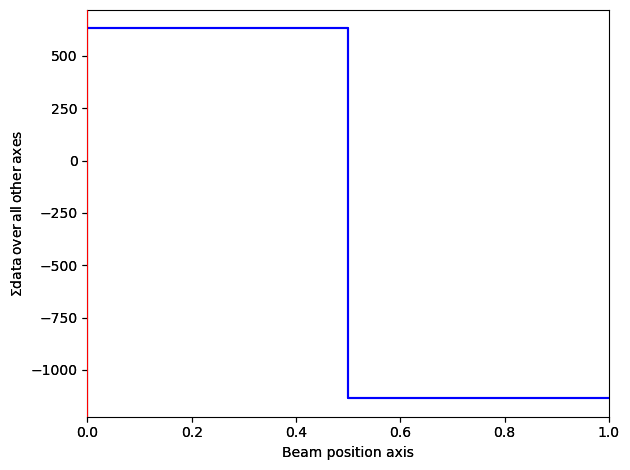

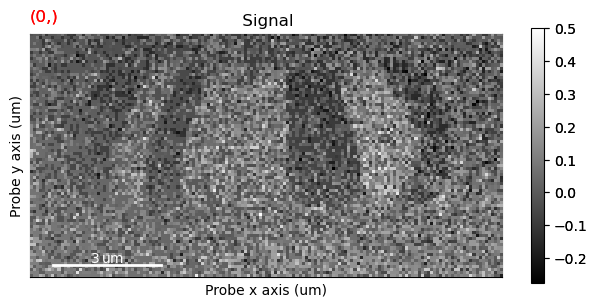

In [ ]:
s_dpc.plot()

## Visualization

Now we can visualize the signal as a magnitude and direction maps: `get_color_signal`, `get_magnitude_signal` and `get_color_image_with_indicator`.

The two former returns a HyperSpy signal, while the latter interfaces directly with the matplotlib backend making it more customizable.

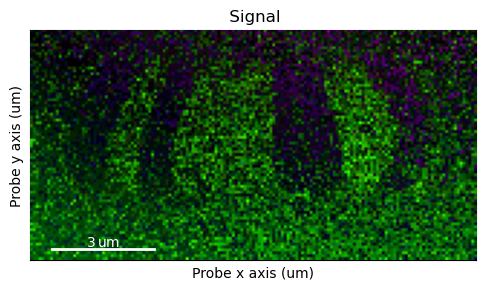

In [ ]:
s_color = s_dpc.get_color_signal()
s_color.plot()

`get_magnitude_signal` gives the magnitude of the beam shift vector. Which can be useful for visualizing the domain walls.

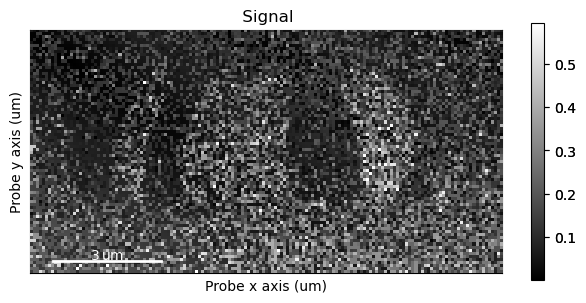

In [ ]:
s_magnitude = s_dpc.get_magnitude_signal()
s_magnitude.plot()

The `get_color_image_with_indicator` method has a large degree of customizability, which is useful when making images for presentations, posters or articles.

By default it returns a matplotlib figure object, which can be saved directly

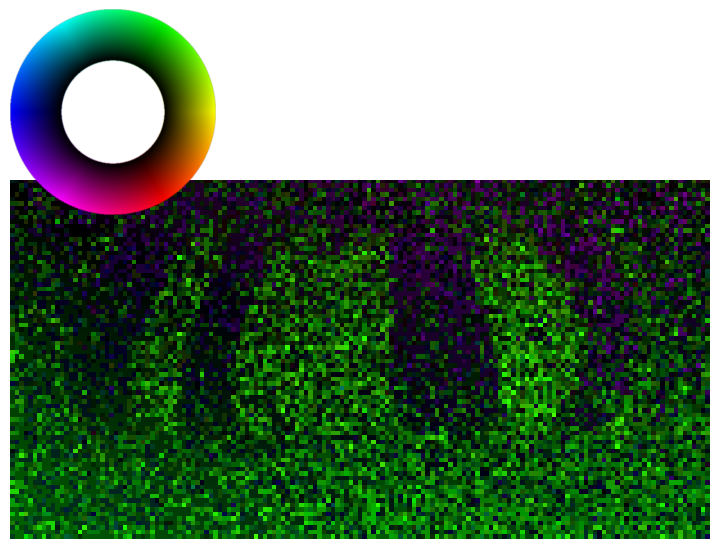

In [ ]:
fig = s_dpc.get_color_image_with_indicator()
fig.savefig("dpc_image.png")

One way quick-and-dirty of suppressing the contrast from the nanocrystalline grains is by blurring.
This suppresses the contrast from the rapidly varying grain, leading to an enhancing of the contrast from the large features, like the ferromagnetic domains.

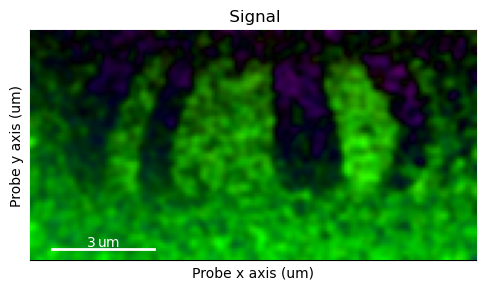

In [ ]:
s_dpc_blur = s_dpc.gaussian_blur(1.2)
s_dpc_blur.get_color_signal().plot()

## Bivariate histogram

Lastly, we can visualize the 2-dimensional histogram of the beam shifts.

Tip: press the H key on your keyboard, to tune the intensity in the image.

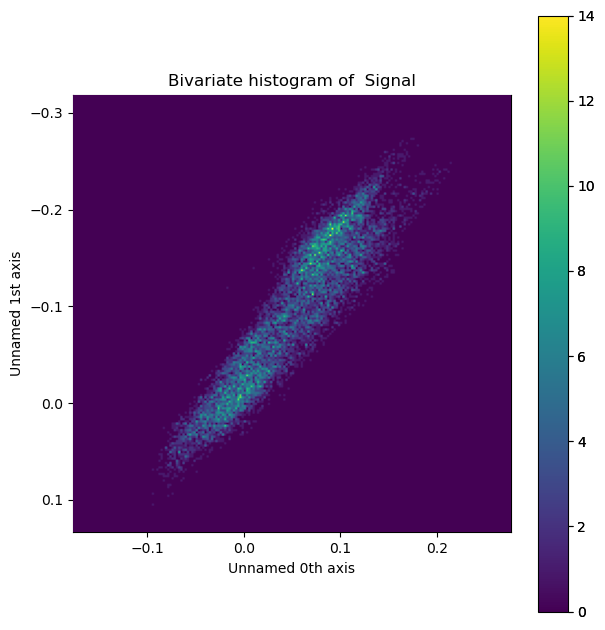

In [ ]:
s_hist = s_dpc_blur.get_bivariate_histogram()
s_hist.plot(cmap='viridis')